## Imports

In [61]:
# Pytorch
import torch
from torch.nn import CrossEntropyLoss, Conv2d, Linear, ReLU, Sequential, Sigmoid, Tanh, Softmax, MSELoss, Dropout, LeakyReLU, ELU, RNN
from torch.optim import SGD, Adam
from torch.nn.functional import mse_loss

# helper
import numpy as np
from math import sqrt, pi as PI
import copy

# Visualization
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Data acquisition

In [2]:
DATA_FOLDER = 'datasets/'
BC_NEW_DENSE_FOLDER = join(DATA_FOLDER, 'bc_new_dense')
ZIG_ZAG2_PATH = join(BC_NEW_DENSE_FOLDER, 'zig_zag2.csv')
ANCHORS_PATH = join(BC_NEW_DENSE_FOLDER, 'anchors_bc_atrium_dense.csv')

In [3]:
data_raw = pd.read_csv(ZIG_ZAG2_PATH)
data_raw

,timestamp,device_id,system_id,anchor_id,px,py,pz,theta_x,theta_y,theta_z,...,dist_var,txpower,rssi,ble_channel,calib_param_tx,calib_param_n,acc_x,acc_y,acc_z,is_step_detected
0,1557062000727,14954135790684542069,7586,NaN,NaN,NaN,NaN,0.947485,0.055430,1.289884,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.275427,8.064031,5.166058,0.0
1,1557062000731,16616973326163504182,7592,dc:8b:28:54:d7:8d,NaN,NaN,NaN,NaN,NaN,NaN,...,0.178929,NaN,-71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1557062000741,14954135790684542069,7586,NaN,NaN,NaN,NaN,0.947991,0.051225,1.293103,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.519719,8.078402,5.486990,0.0
3,1557062000748,16616973326163504182,7592,b8:08:cf:a0:bf:1d,NaN,NaN,NaN,NaN,NaN,NaN,...,0.822649,NaN,-61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1557062000748,16616973326163504182,7582,1-250,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-77.0,-83.0,NaN,-77.0,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22874,1557062212254,28486,115200,0x6F3F,3.75000,7.111000,1.300000,NaN,NaN,NaN,...,NaN,NaN,-80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22875,1557062210445,16616973326163504182,7592,dc:8b:28:54:d7:f1,NaN,NaN,NaN,NaN,NaN,NaN,...,5.866084,NaN,-65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22876,1557062210447,14954135790684542069,7586,NaN,NaN,NaN,NaN,1.068343,-0.014032,-1.169306,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.175955,9.929751,4.260740,0.0
22877,1557062212306,28486,115200,0x6F2B,3.87000,6.940000,1.300000,NaN,NaN,NaN,...,NaN,NaN,-86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_anchors = pd.read_csv(ANCHORS_PATH)
data_anchors

,system_id,anchor_id,px,py,pz,theta_x,theta_y,theta_z,scale_x,scale_y
0,115200,0x6F2B,15.1070,25.2470,1.8120,NaN,NaN,NaN,NaN,NaN
1,115200,0x6F29,2.0550,45.6500,1.8780,NaN,NaN,NaN,NaN,NaN
2,115200,0x6F13,13.8270,7.9280,1.9050,NaN,NaN,NaN,NaN,NaN
3,115200,0x6F3F,1.9350,3.7260,1.9970,NaN,NaN,NaN,NaN,NaN
4,7581,u1uwhdqdy4vx2q0,0.0000,10.4900,1.6100,1.5708,0.0,1.57080,1.050,0.63
5,7581,9iaj4ym9u2shxdh,6.5390,0.9600,1.5550,1.5708,0.0,3.14159,0.575,0.42
6,7581,xehph6l77u7smwo,0.0000,18.7080,1.4350,1.5708,0.0,1.57080,0.420,0.59
7,7581,53saut0wvhrpeyk,13.8480,7.3670,1.4560,1.5708,0.0,-1.57080,0.350,0.54
8,7592,dc:8b:28:54:da:bc,0.2250,30.8470,0.9360,NaN,NaN,NaN,NaN,NaN
9,7592,dc:8b:28:54:d8:05,2.7250,7.3140,5.1600,NaN,NaN,NaN,NaN,NaN


## Data preprocessing

In [5]:
data_anchors.drop(['system_id', 'theta_x', 'theta_y', 'theta_z', 'scale_x', 'scale_y'], axis=1, inplace=True)
data_anchors.rename({'px': 'anchor_px', 'py': 'anchor_py', 'pz': 'anchor_pz'}, axis=1, inplace=True)
data_anchors.anchor_id = data_anchors.anchor_id.str.strip()

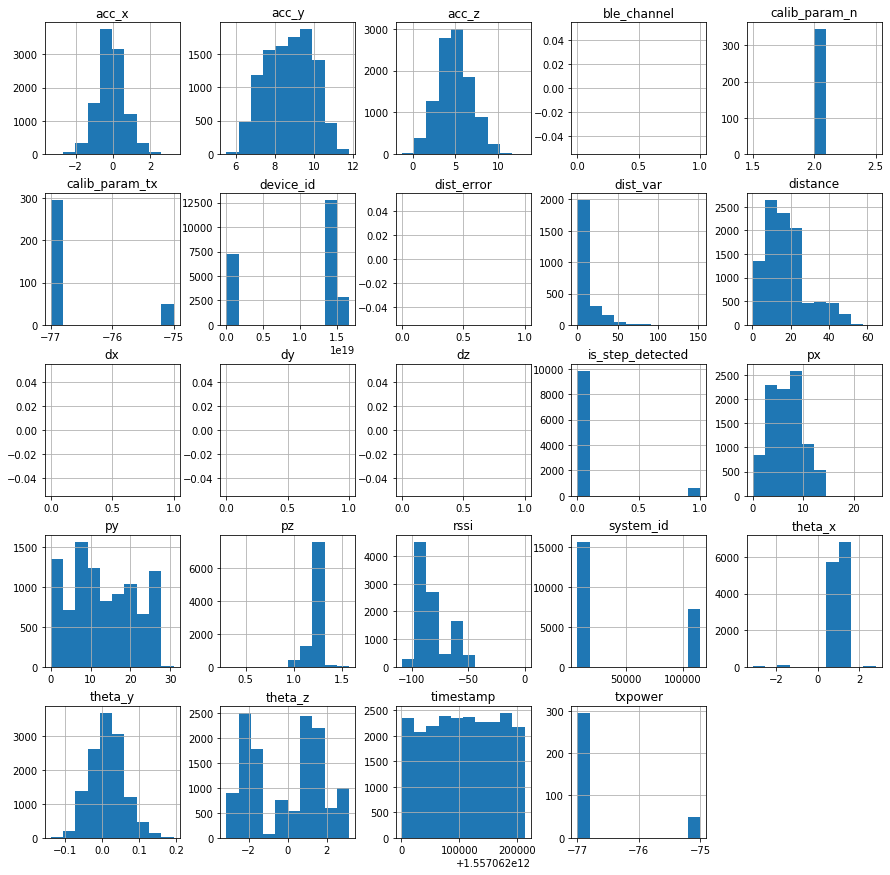

In [6]:
data_raw.hist(figsize=(15,15));

In [7]:
data_raw.system_id.value_counts()

7586      10457
115200     7196
7592       2533
7585       2078
7582        346
7581        269
Name: system_id, dtype: int64

- 115200, Pozyx, ultra wideband signals (good accuracy, not phone compatible), used as baseline
- 7581, Pixlive, image recognition (very good accuracy, only few).
- 7592, RTT, wifi time-of-flight measurements (not so good accuracy)
- 7582, Bluetooth beacons, RSSI measurements (bad accuracy)
- 7585, Tango, used for ground truth position

In [8]:
system_id_map = {
    115200: 'pozyx',
    7581: 'pixlive',
    7592: 'wifi',
    7582: 'bluetooth',
    7585: 'tango'
}

In [9]:
data_raw['system'] = data_raw.system_id.map(system_id_map)

In [10]:
columns_of_interest = ['timestamp', 'system', 'px', 'py', 'pz', 'distance', 'rssi', 'anchor_id']
data = data_raw[columns_of_interest].copy()
data = data[data.system != 'pozyx']
data.dropna(subset=['system'], inplace=True)
data = data.merge(data_anchors, on='anchor_id').copy()
data.sort_values('timestamp', inplace=True)
data.drop_duplicates(['timestamp', 'system', 'anchor_id'], inplace=True)
data.dropna(subset=['system'], inplace=True)
data.reset_index(inplace=True, drop=True)

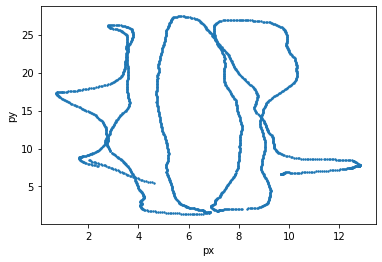

In [11]:
data[data.system == 'tango'].plot.scatter('px', 'py', s=2)

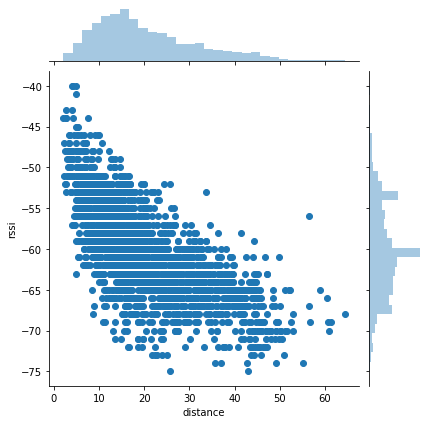

In [12]:
sns.jointplot(x='distance', y='rssi', data=data[data.system == 'wifi'])

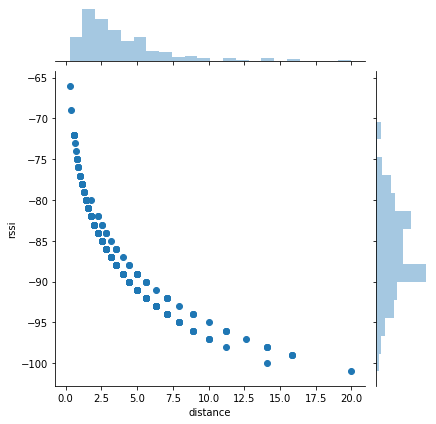

In [13]:
sns.jointplot(x='distance', y='rssi', data=data[data.system == 'bluetooth'])

In [14]:
data_of_interest = data_raw[columns_of_interest]
data_of_interest.head()

,timestamp,system,px,py,pz,distance,rssi,anchor_id
0,1557062000727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1557062000731,wifi,NaN,NaN,NaN,43.299000,-71.0,dc:8b:28:54:d7:8d
2,1557062000741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1557062000748,wifi,NaN,NaN,NaN,10.181000,-61.0,b8:08:cf:a0:bf:1d
4,1557062000748,bluetooth,NaN,NaN,NaN,1.995262,-83.0,1-250


#### make the system timestamps match the tango timestamps

In [15]:
last_tango_timestamp = None
for idx, row in reversed(list(data.iterrows())):
    if row['system'] == 'tango':
        last_tango_timestamp = row['timestamp']
    else:
        data.loc[idx, 'timestamp'] = last_tango_timestamp

In [16]:
data.system.value_counts()

wifi         2533
tango        2075
bluetooth     346
pixlive       269
Name: system, dtype: int64

In [17]:
data.drop_duplicates(['timestamp', 'system', 'anchor_id']).system.value_counts()

wifi         2533
tango        2075
bluetooth     342
pixlive        93
Name: system, dtype: int64

In [18]:
data.drop_duplicates(['timestamp', 'system', 'anchor_id'], keep='last', inplace=True)

In [19]:
data_tango = data.query('system == "tango"').copy()
data_wifi = data.query('system == "wifi"').copy()
data_bluetooth = data.query('system == "bluetooth"').copy()
data_pixlive = data.query('system == "pixlive"').copy()

In [20]:
data_tango.describe()

,timestamp,px,py,pz,distance,rssi,anchor_px,anchor_py,anchor_pz
count,2.075000e+03,2075.000000,2075.000000,2075.000000,0.0,0.0,2.075000e+03,2.075000e+03,2.075000e+03
mean,1.557062e+12,6.434767,13.633579,1.127115,NaN,NaN,9.459700e+00,5.694400e+00,1.254200e+00
std,6.064037e+04,2.957714,7.812754,0.072852,NaN,NaN,1.776785e-15,8.883925e-16,4.441963e-16
min,1.557062e+12,0.731951,1.390544,0.982195,NaN,NaN,9.459700e+00,5.694400e+00,1.254200e+00
25%,1.557062e+12,3.634454,7.341287,1.073898,NaN,NaN,9.459700e+00,5.694400e+00,1.254200e+00
50%,1.557062e+12,6.733529,12.813205,1.115119,NaN,NaN,9.459700e+00,5.694400e+00,1.254200e+00
75%,1.557062e+12,8.901272,20.338429,1.173710,NaN,NaN,9.459700e+00,5.694400e+00,1.254200e+00
max,1.557062e+12,12.846235,27.421302,1.349566,NaN,NaN,9.459700e+00,5.694400e+00,1.254200e+00


In [21]:
data_tango.drop(['system', 'distance', 'rssi', 'anchor_id', 'anchor_px', 'anchor_py', 'anchor_pz'], axis=1, inplace=True)

In [22]:
data_wifi.describe()

,timestamp,px,py,pz,distance,rssi,anchor_px,anchor_py,anchor_pz
count,2.533000e+03,0.0,0.0,0.0,2533.000000,2533.000000,2533.000000,2533.000000,2533.000000
mean,1.557062e+12,NaN,NaN,NaN,20.188377,-60.373470,7.216227,19.141247,1.754479
std,6.065890e+04,NaN,NaN,NaN,10.960980,5.585424,5.914738,12.638572,1.490833
min,1.557062e+12,NaN,NaN,NaN,2.106000,-75.000000,0.211000,3.762000,0.915000
25%,1.557062e+12,NaN,NaN,NaN,12.069000,-64.000000,0.225000,7.314000,0.917000
50%,1.557062e+12,NaN,NaN,NaN,17.481000,-61.000000,6.560000,16.064000,0.936000
75%,1.557062e+12,NaN,NaN,NaN,26.359000,-56.000000,13.801000,30.847000,2.500000
max,1.557062e+12,NaN,NaN,NaN,64.387000,-40.000000,14.937000,42.954000,5.160000


In [23]:
data_wifi.drop(['system', 'px', 'py', 'pz'], axis=1, inplace=True)

In [24]:
data_bluetooth.describe()

,timestamp,px,py,pz,distance,rssi,anchor_px,anchor_py,anchor_pz
count,3.420000e+02,0.0,0.0,0.0,342.000000,342.000000,342.000000,342.000000,342.0
mean,1.557062e+12,NaN,NaN,NaN,3.763466,-86.035088,7.950462,10.450810,1.5
std,6.164827e+04,NaN,NaN,NaN,2.913743,6.016980,4.815091,4.540242,0.0
min,1.557062e+12,NaN,NaN,NaN,0.281838,-101.000000,2.069000,3.722000,1.5
25%,1.557062e+12,NaN,NaN,NaN,1.778279,-90.000000,2.069000,7.683000,1.5
50%,1.557062e+12,NaN,NaN,NaN,2.818383,-86.000000,11.881000,7.683000,1.5
75%,1.557062e+12,NaN,NaN,NaN,5.011872,-82.000000,11.881000,14.850000,1.5
max,1.557062e+12,NaN,NaN,NaN,19.952623,-66.000000,11.881000,14.850000,1.5


In [25]:
data_bluetooth.drop(['system', 'px', 'py', 'pz'], axis=1, inplace=True)

In [26]:
data_pixlive.describe()

,timestamp,px,py,pz,distance,rssi,anchor_px,anchor_py,anchor_pz
count,9.300000e+01,93.000000,93.000000,93.000000,0.0,0.0,93.000000,93.000000,93.000000
mean,1.557062e+12,7.332127,7.177303,1.233497,NaN,NaN,7.296129,6.610043,1.516903
std,7.538045e+04,3.811949,4.641095,0.332314,NaN,NaN,5.442524,5.572623,0.063248
min,1.557062e+12,1.767261,2.386364,0.362872,NaN,NaN,0.000000,0.960000,1.435000
25%,1.557062e+12,3.283977,3.188191,0.960618,NaN,NaN,0.000000,0.960000,1.456000
50%,1.557062e+12,6.205302,7.347254,1.392548,NaN,NaN,6.539000,7.367000,1.555000
75%,1.557062e+12,12.070187,9.042532,1.459458,NaN,NaN,13.848000,10.490000,1.555000
max,1.557062e+12,12.187889,18.150848,1.571681,NaN,NaN,13.848000,18.708000,1.610000


In [27]:
data_pixlive.drop(['system', 'distance', 'rssi'], axis=1, inplace=True)

In [65]:
data_processed = data_tango.copy()

for anchor_id in data_wifi.anchor_id.unique():
    anchor_data = data_wifi.query('anchor_id == @anchor_id')
    anchor_data = anchor_data.drop('anchor_id', axis=1)
    anchor_data = anchor_data.rename(lambda x: x if x == 'timestamp' else x + '_' + anchor_id, axis=1)
    data_processed = data_processed.merge(anchor_data, how='left', on='timestamp')
    
for anchor_id in data_bluetooth.anchor_id.unique():
    anchor_data = data_bluetooth.query('anchor_id == @anchor_id')
    anchor_data = anchor_data.drop('anchor_id', axis=1)
    anchor_data = anchor_data.rename(lambda x: x if x == 'timestamp' else x + '_' + anchor_id, axis=1)
    data_processed = data_processed.merge(anchor_data, how='left', on='timestamp')
    
for anchor_id in data_pixlive.anchor_id.unique():
    anchor_data = data_pixlive.query('anchor_id == @anchor_id')
    anchor_data = anchor_data.drop('anchor_id', axis=1)
    anchor_data = anchor_data.rename(lambda x: x if x == 'timestamp' else x + '_' + anchor_id, axis=1)
    data_processed = data_processed.merge(anchor_data, how='left', on='timestamp')

In [66]:
data_processed.shape

(2075, 88)

In [67]:
data_processed.head()

,timestamp,px,py,pz,distance_dc:8b:28:54:d7:8d,rssi_dc:8b:28:54:d7:8d,anchor_px_dc:8b:28:54:d7:8d,anchor_py_dc:8b:28:54:d7:8d,anchor_pz_dc:8b:28:54:d7:8d,distance_b8:08:cf:a0:bf:1d,...,pz_xehph6l77u7smwo,anchor_px_xehph6l77u7smwo,anchor_py_xehph6l77u7smwo,anchor_pz_xehph6l77u7smwo,px_u1uwhdqdy4vx2q0,py_u1uwhdqdy4vx2q0,pz_u1uwhdqdy4vx2q0,anchor_px_u1uwhdqdy4vx2q0,anchor_py_u1uwhdqdy4vx2q0,anchor_pz_u1uwhdqdy4vx2q0
0,1557062000787,9.716898,6.655635,1.086262,43.299,-71.0,12.019,42.954,0.922,10.181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1557062000886,9.708852,6.656457,1.085010,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1557062000992,9.703813,6.652800,1.085014,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1557062001096,9.700219,6.653879,1.085057,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1557062001189,9.697931,6.654535,1.088706,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
data_processed.describe()

,timestamp,px,py,pz,distance_dc:8b:28:54:d7:8d,rssi_dc:8b:28:54:d7:8d,anchor_px_dc:8b:28:54:d7:8d,anchor_py_dc:8b:28:54:d7:8d,anchor_pz_dc:8b:28:54:d7:8d,distance_b8:08:cf:a0:bf:1d,...,pz_xehph6l77u7smwo,anchor_px_xehph6l77u7smwo,anchor_py_xehph6l77u7smwo,anchor_pz_xehph6l77u7smwo,px_u1uwhdqdy4vx2q0,py_u1uwhdqdy4vx2q0,pz_u1uwhdqdy4vx2q0,anchor_px_u1uwhdqdy4vx2q0,anchor_py_u1uwhdqdy4vx2q0,anchor_pz_u1uwhdqdy4vx2q0
count,2.075000e+03,2075.000000,2075.000000,2075.000000,362.000000,362.000000,3.620000e+02,3.620000e+02,362.000,361.000000,...,10.000000,10.0,10.000,10.000,15.000000,15.000000,15.000000,15.0,1.500000e+01,1.500000e+01
mean,1.557062e+12,6.434767,13.633579,1.127115,36.916588,-65.875691,1.201900e+01,4.295400e+01,0.922,11.090798,...,0.611819,0.0,18.708,1.435,3.023663,9.807246,0.800103,0.0,1.049000e+01,1.610000e+00
std,6.064037e+04,2.957714,7.812754,0.072852,8.913632,3.452650,1.778815e-15,7.115262e-15,0.000,4.861576,...,0.166662,0.0,0.000,0.000,0.289652,0.537278,0.154638,0.0,1.838704e-15,2.298380e-16
min,1.557062e+12,0.731951,1.390544,0.982195,17.342000,-74.000000,1.201900e+01,4.295400e+01,0.922,2.106000,...,0.362872,0.0,18.708,1.435,2.235586,8.670681,0.535845,0.0,1.049000e+01,1.610000e+00
25%,1.557062e+12,3.634454,7.341287,1.073898,29.956750,-68.000000,1.201900e+01,4.295400e+01,0.922,7.247000,...,0.484644,0.0,18.708,1.435,2.956352,9.472895,0.688410,0.0,1.049000e+01,1.610000e+00
50%,1.557062e+12,6.733529,12.813205,1.115119,37.839500,-66.000000,1.201900e+01,4.295400e+01,0.922,10.534000,...,0.634873,0.0,18.708,1.435,3.093078,9.979961,0.840206,0.0,1.049000e+01,1.610000e+00
75%,1.557062e+12,8.901272,20.338429,1.173710,43.833250,-64.000000,1.201900e+01,4.295400e+01,0.922,14.763000,...,0.743168,0.0,18.708,1.435,3.184804,10.230257,0.925531,0.0,1.049000e+01,1.610000e+00
max,1.557062e+12,12.846235,27.421302,1.349566,61.385000,-52.000000,1.201900e+01,4.295400e+01,0.922,36.383000,...,0.816049,0.0,18.708,1.435,3.438859,10.402106,0.981562,0.0,1.049000e+01,1.610000e+00


In [69]:
data_processed.fillna(0, inplace=True)

In [103]:
data_input = torch.FloatTensor(data_processed.drop(['timestamp', 'px', 'py', 'pz'], axis=1).values)[:2000]
data_target = torch.FloatTensor(data_processed.filter(['px', 'py', 'pz']).values)[:2000]

In [104]:
_, n_attr = data_input.shape
_, n_out = data_target.shape

In [112]:
N_EPOCHS = 2000
BATCH_SIZE = 100

criterion = MSELoss()

In [113]:
def train_model(model, train_input, train_target, test_input, test_target, nb_epochs=N_EPOCHS, batch_size=BATCH_SIZE):
    """Train a model"""
    
    optimizer = Adam(model.parameters())
    train_losses = []
    test_losses = []

    for _ in range(nb_epochs):
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            loss = criterion(output, train_target.narrow(0, b, batch_size))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_output = model(train_input)
        train_loss = criterion(train_output, train_target)
        train_losses.append(train_loss.item())
        
        test_output = model(test_input)
        test_loss = criterion(test_output, test_target)
        test_losses.append(test_loss.item())
        
    return train_losses, test_losses

In [114]:
def plot_loss_evolution(train_losses, test_losses):
    plt.plot(train_losses, c='blue')
    plt.plot(test_losses, c='orange')
    plt.legend(['train loss', 'test loss'])
    plt.ylim(0, 100)
    plt.grid();

In [131]:
def plot_simulation(positions):
    plt.plot(*positions.T)
    plt.plot(*positions[0], '*', c='green', markersize=15)
    plt.plot(*positions[-1], '*', c='orange', markersize=15);

In [132]:
RATIO = 0.8
split = int(RATIO * data_input.size(0))

train_input = data_input[:split]
train_target = data_target[:split]
test_input = data_input[split:]
test_target = data_target[split:]

CPU times: user 16.7 s, sys: 5.18 s, total: 21.9 s
Wall time: 11 s


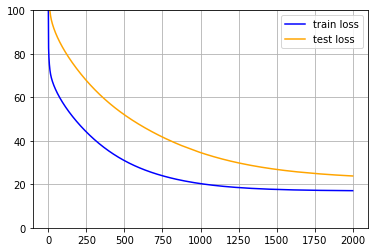

In [133]:
%%time

model = Sequential(
    Linear(n_attr, n_out)
)

train_losses, test_losses = train_model(model, train_input, train_target,
                                        test_input=test_input, test_target=test_target)

plot_loss_evolution(train_losses, test_losses)

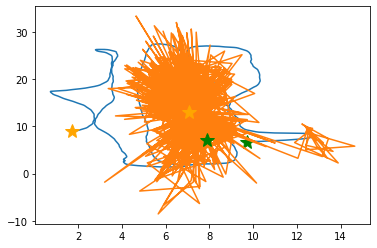

In [134]:
plot_simulation(data_target[:,:2])
plot_simulation(model(data_input).detach()[:,:2])

CPU times: user 4min 42s, sys: 1min 49s, total: 6min 31s
Wall time: 2min 11s


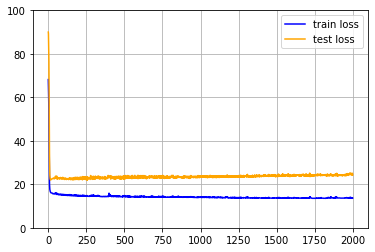

In [129]:
%%time

model = Sequential(
    Linear(n_attr, 256), ReLU(),
    Linear(256, 128), ReLU(),
    Linear(128, 64), ReLU(),
    Linear(64, n_out)
)

train_losses, test_losses = train_model(model, train_input, train_target,
                                        test_input=test_input, test_target=test_target)

plot_loss_evolution(train_losses, test_losses)

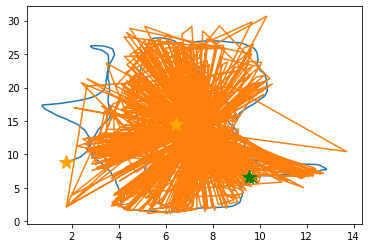

In [130]:
plot_simulation(data_target[:,:2])
plot_simulation(model(data_input).detach()[:,:2])